In [18]:
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
import numpy as np
import torchaudio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import os

# Data

In [19]:
# Using IDMT-SMT-BASS/PS (plucking style)
# Prepare dataset in the form: waveform, sample_rate, label
# labels: 0 - FS (fingerstyle), 1 - ST (slap-thumb), 2 - SP (slap-pop)

class BassDataset(Dataset):
    def __init__(self, root_dir, classes=('FS', 'ST', 'SP'), resample_freq=None):
        self.labels = { i: label for i, label in enumerate(classes) }
        self.data = []
        for label_idx, label in self.labels.items():
            path = os.path.join(root_dir, label)
            for file in os.listdir(path):
                if file.endswith('.wav'):
                    waveform, sample_rate = torchaudio.load(os.path.join(path, file))
                    if resample_freq:
                        waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=resample_freq)(waveform)
                        sample_rate = resample_freq
                    
                    # Remove leading and trailing silence
                    waveform, _ = librosa.effects.trim(waveform.numpy()[0], top_db=20)
                    waveform = torch.from_numpy(waveform).unsqueeze(0)
                    labeled_data = (waveform, sample_rate, label_idx)
                    self.data.append(labeled_data)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        waveform, sample_rate, label_idx = self.data[idx]
        return waveform, sample_rate, label_idx

In [20]:
root_dir = 'IDMT-SMT-BASS/PS/'    

def collate_fn(data):
    tensors, sample_rates, targets = [], [], []
    for waveform, sample_rate, label_idx in data:
        tensors.append(waveform)
        sample_rates.append(sample_rate)
        # one hot encoding
        # targets.append([1 if i == label_idx else 0 for i in range(3)])
        targets.append(label_idx)
    tensors = pad_sequence([tensor.t() for tensor in tensors], batch_first=True)
    tensors = tensors.permute(0, 2, 1)
    return tensors, sample_rates, torch.tensor(targets)

classes = ('FS', 'MU', 'ST', 'SP', 'PK')
dataset = BassDataset(root_dir, classes=classes, resample_freq=8000)

# Train test split
train_count = int(len(dataset) * 0.8)
test_count = len(dataset) - train_count
train_data, test_data = torch.utils.data.random_split(dataset, [train_count, test_count])

batch_size = 256
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)
test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

In [21]:
w, sr, l = next(iter(train_dataloader))
print(w.shape, l.shape)

torch.Size([256, 1, 28160]) torch.Size([256])


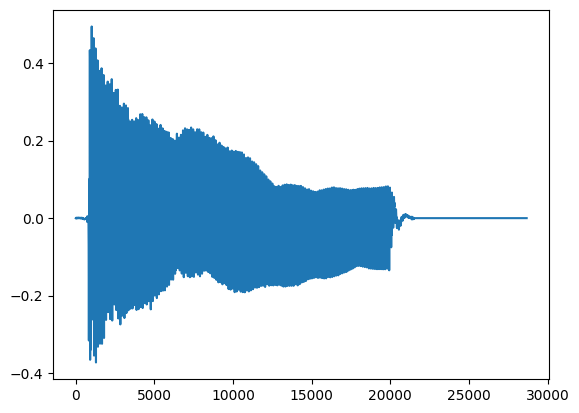

In [22]:
# Visualize one audio sample
waveforms, sample_rates, label_idxs = next(iter(train_dataloader))
waveform, sr = waveforms[0][0], sample_rates[0]

plt.figure()
plt.plot(waveform)

In [23]:
Audio(waveform, rate=sr)

### TODO
1. Use spectrogram

### Notes
Dataloader will return tensor of size 4 with (waveform, sample_rate, label_idx) for each sample

# Model

In [24]:
from torch import nn

class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.n_output = n_output
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)
        

In [25]:
class M18(nn.Module):
    def __init__(self, n_input=1, n_output=4, stride=16, n_channel=32):
        super().__init__()
        self.n_output = n_output
        
        
    def forward(self, x):
        pass

In [26]:
model = M5(n_input=1, n_output=len(classes), stride=16)
device = "cpu"
model.to(device)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=5, bias=True)
)

In [27]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

In [28]:
def train(model, epoch, log_interval, losses):
    model.train()
    
    for batch_idx, (data, _ , target) in enumerate(train_dataloader):
        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        # data = transform(data)
        output = model(data)
        
        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        # if batch_idx % log_interval == 0:
        #     print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_dataloader.dataset)} ({100. * batch_idx / len(train_dataloader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        # pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())
    return losses

def test(model, epoch):
    model.eval()
    correct = 0
    for data, _, target in test_dataloader:
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        pred = output.argmax(dim=-1)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
    print(f"Test Epoch: {epoch}\tAccuracy: {correct}/{len(test_dataloader.dataset)} ({100. * correct / len(test_dataloader.dataset):.0f}%)\n\n")
    

In [29]:
epoch = 20
log_interval = 10

losses = []
for e in range(1, epoch + 1):
    losses = train(model, e, log_interval, losses)
    test(model, e)
    scheduler.step()

Test Epoch: 1	Accuracy: 94/469 (20%)

Test Epoch: 2	Accuracy: 124/469 (26%)

Test Epoch: 3	Accuracy: 266/469 (57%)

Test Epoch: 4	Accuracy: 346/469 (74%)

Test Epoch: 5	Accuracy: 327/469 (70%)

Test Epoch: 6	Accuracy: 346/469 (74%)

Test Epoch: 7	Accuracy: 393/469 (84%)

Test Epoch: 8	Accuracy: 344/469 (73%)

Test Epoch: 9	Accuracy: 401/469 (86%)

Test Epoch: 10	Accuracy: 415/469 (88%)

Test Epoch: 11	Accuracy: 401/469 (86%)

Test Epoch: 12	Accuracy: 368/469 (78%)

Test Epoch: 13	Accuracy: 392/469 (84%)

Test Epoch: 14	Accuracy: 425/469 (91%)

Test Epoch: 15	Accuracy: 415/469 (88%)

Test Epoch: 16	Accuracy: 415/469 (88%)

Test Epoch: 17	Accuracy: 445/469 (95%)

Test Epoch: 18	Accuracy: 413/469 (88%)

Test Epoch: 19	Accuracy: 434/469 (93%)

Test Epoch: 20	Accuracy: 437/469 (93%)



In [30]:
# Save model
torch.save(model.state_dict(), './m5_model.pt')

In [31]:
# Load model
loaded_model = M5(n_input=1, n_output=len(classes))
loaded_model.load_state_dict(torch.load('./m5_model.pt'))

<All keys matched successfully>

In [32]:
# Test with a sample
import random
waveforms, sample_rates, label_idxs = next(iter(train_dataloader))
i = random.randint(0, len(waveforms) - 1)
waveform, label_idx = waveforms[i], label_idxs[i]
Audio(waveform, rate=sample_rates[i])

In [33]:
loaded_model.eval()
output = loaded_model(waveform.unsqueeze(0))
pred = output.argmax(dim=-1)
print(classes[pred], classes[label_idx])

ST ST
